In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

sns.set(style='whitegrid', palette='muted', font_scale=1.1)

In [2]:
# ==========================================================
# 1. Setup Paths
# ==========================================================
RAW = Path('../data/raw')
PROC = Path('../data/processed')
MODELS = Path('../models')
PROC.mkdir(parents=True, exist_ok=True)
MODELS.mkdir(parents=True, exist_ok=True)

In [3]:
# ==========================================================
# 2. Load and Combine All Datasets
# ==========================================================
files = list(RAW.glob('*.xlsx')) + list(RAW.glob('*.csv'))
if not files:
    raise FileNotFoundError(f"No datasets found in {RAW.resolve()}")

dfs = []
for file in files:
    print(f"📂 Loading: {file.name}")
    if file.suffix == '.xlsx':
        df_temp = pd.read_excel(file)
    else:
        df_temp = pd.read_csv(file)
    dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)
print(f"✅ Combined Dataset Shape: {df.shape}")
df.head()

📂 Loading: Smart_Fertilizer_Recommender_Dataset.xlsx
📂 Loading: Crop and fertilizer dataset (1).csv
📂 Loading: dataset1.csv
📂 Loading: Fertilizer Prediction.csv
📂 Loading: fertilizer_dataset_2000.csv
📂 Loading: fertilizer_dataset_5000.csv
📂 Loading: fertilizer_recommendation_dataset.csv
✅ Combined Dataset Shape: (16592, 49)
📂 Loading: Crop and fertilizer dataset (1).csv
📂 Loading: dataset1.csv
📂 Loading: Fertilizer Prediction.csv
📂 Loading: fertilizer_dataset_2000.csv
📂 Loading: fertilizer_dataset_5000.csv
📂 Loading: fertilizer_recommendation_dataset.csv
✅ Combined Dataset Shape: (16592, 49)


,Crop_Type,Region,Soil_Type,Soil_pH,Nitrogen_Level,Phosphorus_Level,Potassium_Level,Organic_Carbon,Moisture_Content,Rainfall_mm,...,Humidity,Moisture,Soil Type,Crop Type,Phosphorous,Fertilizer Name,PH,Carbon,Soil,Remark
0,Groundnut,Tamil Nadu,Sandy,4.92,131.63,21.79,242.19,1.57,27.89,955.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sugarcane,Uttar Pradesh,Sandy,7.13,53.08,64.54,65.49,0.57,26.65,756.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Millet,Andhra Pradesh,Sandy,7.79,166.59,86.45,194.20,1.48,15.84,146.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Cotton,Gujarat,Sandy,6.02,100.62,14.05,79.80,0.24,8.00,895.82,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Groundnut,Maharashtra,Silty,7.60,140.05,76.07,59.12,0.95,8.18,876.41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# ==========================================================
# 3. Handle Missing Values
# ==========================================================
print('🔍 Checking for Missing Values...')
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

cat_cols = df.select_dtypes(exclude=np.number).columns
df[cat_cols] = df[cat_cols].apply(lambda x: x.fillna(x.mode()[0]))
print(f"✅ Missing Value Handling Complete — {df.isnull().sum().sum()} missing values remain.")

🔍 Checking for Missing Values...
✅ Missing Value Handling Complete — 0 missing values remain.


In [5]:
# ==========================================================
# 4. Feature Engineering
# ==========================================================
def feature_engineering(df):
    df = df.copy()

    df['NPK_Ratio'] = df['Nitrogen_Level'] / (df['Phosphorus_Level'] + df['Potassium_Level'] + 1e-6)
    df['Fertility_Index'] = (df['Organic_Carbon'] + (df['Moisture_Content'] / 100)) / 2
    df['Temperature_Rainfall_Index'] = df['Temperature_C'] / (df['Rainfall_mm'] + 1)

    # Categorize pH levels
    df['pH_Category'] = pd.cut(
        df['Soil_pH'],
        bins=[0, 5.5, 6.5, 7.5, 14],
        labels=['Acidic', 'Slightly_Acidic', 'Neutral', 'Alkaline']
    )

    # Normalize fertilizer names if inconsistencies exist
    df['Fertilizer_Type'] = df['Fertilizer_Type'].replace({
        'Complex': 'Mixed',
        'MOP': 'Potash',
        'NPK': 'Mixed'
    })

    return df

df = feature_engineering(df)
print(f"✅ Feature Engineering Complete. Total Columns: {len(df.columns)}")

✅ Feature Engineering Complete. Total Columns: 53


In [6]:
# ==========================================================
# 5. Encode Categorical Features
# ==========================================================
categorical_cols = ['Crop_Type', 'Region', 'Soil_Type', 'pH_Category', 'Application_Timing']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

print("✅ Label Encoding Complete.")

✅ Label Encoding Complete.


In [7]:
# ==========================================================
# 6. Feature Scaling
# ==========================================================
scaler = StandardScaler()
num_cols = df.select_dtypes(include=np.number).columns.drop(['Recommended_Quantity_kg_per_acre'])
df[num_cols] = scaler.fit_transform(df[num_cols])
print("✅ Feature Scaling Complete.")

✅ Feature Scaling Complete.


In [8]:
# ==========================================================
# 7. Split Dataset (Train / Validation / Test)
# ==========================================================
train, test = train_test_split(df, test_size=0.15, random_state=42)
train, val = train_test_split(train, test_size=0.15, random_state=42)

train.to_csv(PROC / 'train.csv', index=False)
val.to_csv(PROC / 'val.csv', index=False)
test.to_csv(PROC / 'test.csv', index=False)

print(f"✅ Data Split Complete:")
print(f"Train: {train.shape}, Validation: {val.shape}, Test: {test.shape}")

✅ Data Split Complete:
Train: (11987, 53), Validation: (2116, 53), Test: (2489, 53)


🔤 Encoding categorical columns: ['Fertilizer_Type', 'District_Name', 'Soil_color', 'Crop', 'Fertilizer', 'Link', 'Soil Type', 'Crop Type', 'Fertilizer Name', 'Soil', 'Remark']
✅ Label encoders saved at: ..\models\rf_label_encoders.pkl
✅ Feature matrix shape: (11987, 51) | Target shape: (11987,)


C:\Users\sasik\AppData\Local\Temp\ipykernel_19960\1858255547.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values[:15], y=importances.index[:15], palette='crest')


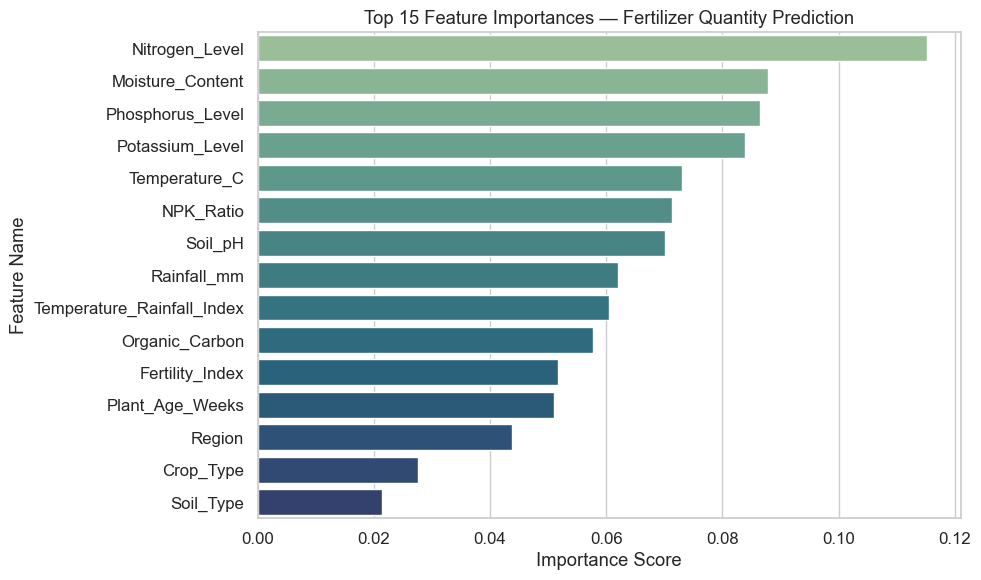

🌾 Top 10 Most Influential Features:
 1. Nitrogen_Level                       Importance: 0.1153
 2. Moisture_Content                     Importance: 0.0879
 3. Phosphorus_Level                     Importance: 0.0864
 4. Potassium_Level                      Importance: 0.0839
 5. Temperature_C                        Importance: 0.0730
 6. NPK_Ratio                            Importance: 0.0714
 7. Soil_pH                              Importance: 0.0702
 8. Rainfall_mm                          Importance: 0.0621
 9. Temperature_Rainfall_Index           Importance: 0.0605
10. Organic_Carbon                       Importance: 0.0578

✅ Feature Importance Visualization Complete!


In [9]:
# ==========================================================
# 8. Feature Importance Visualization (Fixed for Kaggle Data)
# ==========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
import joblib

sns.set(style='whitegrid', palette='muted', font_scale=1.1)

# ------------------------------
# 1. Encode Categorical Columns
# ------------------------------
train_encoded = train.copy()
label_encoders = {}

cat_cols = train_encoded.select_dtypes(exclude=[np.number]).columns
print(f"🔤 Encoding categorical columns: {list(cat_cols)}")

for col in cat_cols:
    le = LabelEncoder()
    train_encoded[col] = le.fit_transform(train_encoded[col].astype(str))
    label_encoders[col] = le

# Save encoders for later use (optional but good practice)
MODELS = Path('../models')
MODELS.mkdir(exist_ok=True, parents=True)
joblib.dump(label_encoders, MODELS / 'rf_label_encoders.pkl')
print(f"✅ Label encoders saved at: {MODELS / 'rf_label_encoders.pkl'}")

# ------------------------------
# 2. Prepare Data for Modeling
# ------------------------------
if 'Recommended_Quantity_kg_per_acre' not in train_encoded.columns:
    raise KeyError("❌ Column 'Recommended_Quantity_kg_per_acre' not found in training data.")
if 'Fertilizer_Type' not in train_encoded.columns:
    raise KeyError("❌ Column 'Fertilizer_Type' not found in training data.")

X = train_encoded.drop(['Recommended_Quantity_kg_per_acre', 'Fertilizer_Type'], axis=1)
y = train_encoded['Recommended_Quantity_kg_per_acre']

print(f"✅ Feature matrix shape: {X.shape} | Target shape: {y.shape}")

# ------------------------------
# 3. Train RandomForest for Feature Importance
# ------------------------------
rf = RandomForestRegressor(n_estimators=150, random_state=42)
rf.fit(X, y)

# ------------------------------
# 4. Compute & Visualize Importances
# ------------------------------
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values[:15], y=importances.index[:15], palette='crest')
plt.title('Top 15 Feature Importances — Fertilizer Quantity Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

# ------------------------------
# 5. Print Top Features
# ------------------------------
print("🌾 Top 10 Most Influential Features:")
for i, (feature, importance) in enumerate(importances.head(10).items(), 1):
    print(f"{i:2d}. {feature:<35}  Importance: {importance:.4f}")

print("\n✅ Feature Importance Visualization Complete!")


In [11]:
# ==========================================================
# 9. Save Artifacts
# ==========================================================
joblib.dump(scaler, MODELS / 'scaler.pkl')
joblib.dump(label_encoders, MODELS / 'label_encoders.pkl')

print(f"✅ Preprocessing Artifacts Saved in: {MODELS.resolve()}")

✅ Preprocessing Artifacts Saved in: C:\Users\sasik\OneDrive\Desktop\AIML Project\models
